# Imports

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

# For matrix operations
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn

# Custom Image Dataset

In [5]:
import os
from torchvision.io import read_image
import pandas as pd
from PIL import Image
import math


def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')

device = get_default_device()

class ImageDataset(Dataset):
    def __init__(self, index_df, root=None, tranformations = None,
                 augmentation = False, default_transformation = None):
        # super().__init__()
        self.root = root
        self.augmentation = augmentation
        self.device = get_default_device()
        self.transformation = None
        self.default_transformation = default_transformation
        if root is None:
          self.root = os.path.join('data', 'data','train','train')
        #initializing the transformation set with the default conversion
        if augmentation:
          self.transformation = [
              default_transformation
          ]
          if tranformations:
            self.transformation.extend(tranformations)

        self.index_file = index_df

    def __len__(self):
        if self.transformation:
          return self.index_file.shape[0] * len(self.transformation)
        return self.index_file.shape[0]

    def __getitem__(self, index):
      if self.transformation:
        transformation_index = math.floor(index / self.index_file.shape[0])
        file_index = index - (self.index_file.shape[0] * transformation_index)
        #print(transformation_index, file_index)
        img_path = os.path.join(self.root, str(self.index_file.iloc[file_index,0]) ,self.index_file.iloc[file_index,1])
        label = self.index_file.iloc[file_index,0]

        #image = read_image(img_path)
        image = Image.open(img_path).convert('RGB')
        image = self.transformation[transformation_index](image)

      else:
        #print(index)
        img_path = os.path.join(self.root, str(self.index_file.iloc[index,0]) ,self.index_file.iloc[index,1])
        #print('got file',img_path)
        label = self.index_file.iloc[index,0]
        #print('got label',label)
        #image = read_image(img_path)
        image = Image.open(img_path).convert('RGB')
        if self.default_transformation:
          image = self.default_transformation(image)
        #print('got img',img.)

      #return image.to(self.device), label
      return image, label

# Image Augmentation

In [6]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
final_size = (224,224)
image_augmentation = [
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.7, saturation=0.7, hue=0.5
                ),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.RandomRotation(degrees=30),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.RandomGrayscale(p=0.7),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.ToTensor(),
                transforms.RandomErasing(
                    p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value="random"
                ),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.ToTensor(),
                transforms.GaussianBlur(kernel_size=7),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
   transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.ToTensor(),
                transforms.RandomInvert(p=0.7),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
        transforms.Compose(
            [
                transforms.RandomResizedCrop(size=final_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
        transforms.Compose(
            [
                transforms.CenterCrop(size=(100, 100)),
                transforms.Resize(final_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
        transforms.Compose(
            [
                transforms.RandomPerspective(
                    distortion_scale=0.5,
                    p=0.5,
                    interpolation=transforms.InterpolationMode.BILINEAR,
                ),
                transforms.Resize(final_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        ),
  transforms.Compose(
            [
                transforms.Resize(final_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)
            ]
        )


]

def get_train_test_split(train_size = 0.8):
  labels = sorted(list(range(100)) * 10)
  file_names = [str(f) + '.jpg' for f in list(range(10))*100]
  data = pd.DataFrame(zip(labels,file_names), columns=['Target','File'])
  all_samples = [i for i in range(data.shape[0])]
  rn.shuffle(all_samples)
  train_offset = int(train_size * len(all_samples))
  train_samples = all_samples[:train_offset]
  test_samples = all_samples[train_offset:]

  train_samples = data.iloc[train_samples,:]
  test_samples = data.iloc[test_samples,:]

  train_samples.reset_index(drop=True, inplace=True)
  test_samples.reset_index(drop=True, inplace=True)
  return train_samples, test_samples


default_transformation = transforms.Compose(
    [
        transforms.Resize(final_size),
        transforms.ToTensor(),
        #transforms.Normalize(mean=mean, std=std)
    ]
)

train_samples, test_samples = get_train_test_split()
train_data = ImageDataset(train_samples, tranformations = image_augmentation,
                          augmentation=True, default_transformation=default_transformation)
test_data = ImageDataset(test_samples, default_transformation=default_transformation)

In [ ]:
for i in range(0,len(train_data),800):
  img, label = train_data.__getitem__(i)
  print(f'Img={img.shape}; Label={label}')
  print('-'*25)

Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------
Img=torch.Size([3, 224, 224]); Label=24
-------------------------


# Visualizations

29
29
29
29
29
29
29


29
29
29


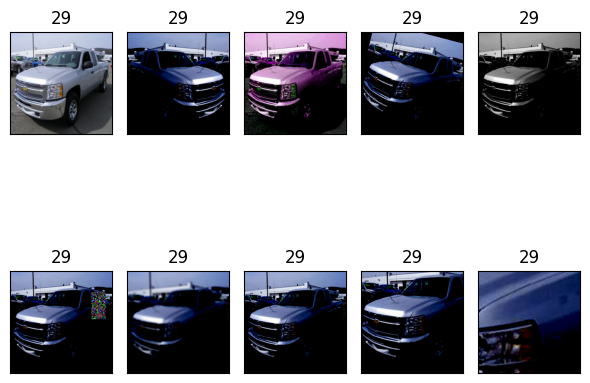

In [ ]:
# For matrix operations
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn

fig, ax = plt.subplots(2, 5)
fig.set_size_inches(6, 6)

index = rn.randint(0, len(train_samples))

for i in range(2):
    for j in range(5):
        l=index
        ax[i, j].imshow(np.transpose(train_data[l][0].cpu().numpy(), (1, 2, 0)), cmap='gray')
        #ax[i, j].set_title(str(l))
        ax[i, j].set_title(str(train_data[l][1]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        index += 800
        print(train_data[l][1])


plt.tight_layout()

In [ ]:
def plot_img(image):
  plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)), cmap='gray')

61
47
81
76
86
33
31
54
83
89


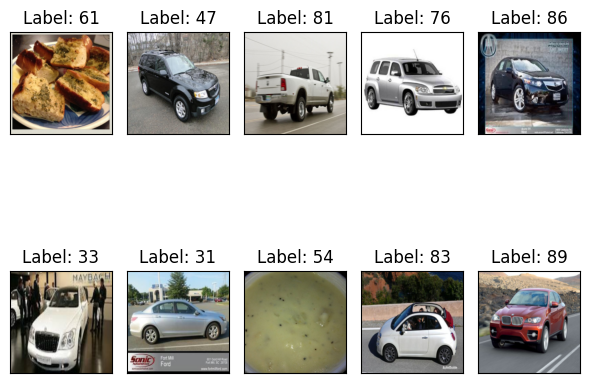

In [ ]:
# For matrix operations
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn

fig, ax = plt.subplots(2, 5)
fig.set_size_inches(6, 6)


for i in range(2):
    for j in range(5):
        l=rn.randint(0, len(test_samples))
        ax[i, j].imshow(np.transpose(test_data[l][0].cpu().numpy(), (1, 2, 0)), cmap='gray')
        ax[i, j].set_title('Label: ' + str(test_data[l][1]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        print(test_data[l][1])


plt.tight_layout()

# Training Loop

In [9]:
from tqdm import tqdm
import gc

def cleanup(model):
  del model
  gc.collect()
  torch.cuda.empty_cache()







def training_loop(model, train_data, test_data, b_size = 32,
                  num_epochs = 20, model_name = 'model1'):

  train_loader = DataLoader(train_data, batch_size = b_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size = b_size, shuffle = False)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  # Function to calculate accuracy
  def calculate_accuracy(loader, model,pbar=None):
      model.eval()
      correct = 0
      total = 0

      with torch.no_grad():
          for data in loader:
              images, labels = data
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels.squeeze()).sum().item()
              if pbar:
                pbar.update(1)
      return 100 * correct / total


  # Training the network
  train_losses, test_losses = [], []
  train_acc, test_acc = [], []
  best_acc = 0
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      print('Training #',epoch)
      with tqdm(total=math.ceil(len(train_data)/b_size)) as pbar:
        for i, data in enumerate(train_loader, 0):
            #print(f'{i}', end = '  ')
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs)
            #print('\n')
            #print(labels)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)


      train_loss = running_loss / len(train_loader)
      train_losses.append(train_loss)
      print('Computing Train Accuracy...')
      with tqdm(total=math.ceil(len(train_data)/b_size)) as pbar:
        train_accuracy = calculate_accuracy(train_loader, model, pbar)
      train_acc.append(train_accuracy)

      test_loss = 0.0
      print('Testing #',epoch)
      model.eval()
      with torch.no_grad():
        with tqdm(total=math.ceil(len(test_data)/b_size)) as pbar:
          for data in test_loader:
              images, labels = data
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels.squeeze())
              test_loss += loss.item()
              pbar.update(1)

      test_loss /= len(test_loader)
      test_losses.append(test_loss)
      print('Computing Test Accuracy...')
      with tqdm(total=math.ceil(len(test_data)/b_size)) as pbar:
        test_accuracy = calculate_accuracy(test_loader, model, pbar)
      test_acc.append(test_accuracy)


      print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}% \n')
      print('_'*30)
      print()

      if test_accuracy > best_acc:
        torch.save(model.state_dict(), f'{model_name}-{int(test_accuracy)}.pth')
        best_acc = test_accuracy
        print('*'*30)
        print(f'\nBest Epoch so far: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}% \n')
        print('*'*30)
        print('\n')
  return train_acc, train_losses, test_acc, test_losses




In [10]:
class ModelHead(nn.Module):
    def __init__(self, in_features, num_classes=100):
        super(ModelHead, self).__init__()
        self.custom_classifier = nn.Sequential(
          nn.Linear(in_features, 1024),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        return self.custom_classifier(x)

# ResNet 152

In [ ]:
model = models.resnet152(weights='IMAGENET1K_V2')
train_samples, test_samples = get_train_test_split(0.85)
train_data = ImageDataset(train_samples, tranformations = image_augmentation,
                          augmentation=True, default_transformation=default_transformation)
test_data = ImageDataset(test_samples, default_transformation=default_transformation)

for para in model.parameters():
    para.requires_grad = False

num_features = model.fc.in_features
model.fc = ModelHead(num_features)
model.to(get_default_device())


#unfreeze fc
for param in model.fc.parameters():
    param.requires_grad = True

#unfreeze layer 4
for param in model.layer4.parameters():
    param.requires_grad = True

#unfreeze layer 3
for param in model.layer3.parameters():
    param.requires_grad = True

#unfreeze layer 2
for param in model.layer2.parameters():
    param.requires_grad = True

#unfreeze layer 1
for param in model.layer1.parameters():
    param.requires_grad = True

#unfreeze bn1
for param in model.bn1.parameters():
  param.requires_grad = True

for param in model.conv1.parameters():
  param.requires_grad = True


training_loop(model, train_samples, test_samples, num_epochs=10, b_size=16,
              model_name='resnet152')


Training # 0


  5%|▍         | 27/585 [00:09<03:10,  2.93it/s]


KeyboardInterrupt: 

In [ ]:
cleanup(model)

# ViT

## Unfreeze Layers 23 Onwards

In [ ]:
model = torchvision.models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)

train_samples, test_samples = get_train_test_split(0.85)
train_data = ImageDataset(train_samples, tranformations = image_augmentation,
                          augmentation=True, default_transformation=default_transformation)
test_data = ImageDataset(test_samples, default_transformation=default_transformation)

for para in model.parameters():
    para.requires_grad = False

num_features = model.heads.head.in_features
model.heads.head = ModelHead(num_features)
model.to(get_default_device())

tunable_layers = 23 #onwards
tune_layers = [f'encoder.layers.encoder_layer_{str(i)}' for i in range(tunable_layers,24)]
tune_layers.extend(['encoder.ln.weight','encoder.ln.bias', 'heads.head', 'heads.head'])


for name, params in model.named_parameters():
  exists = False
  for t in tune_layers:
    if t in name:
      exists = True
      break
  if exists:
    params.requires_grad = True
    #print(name,'Unfrozen')


for name, params in model.named_parameters():
  if params.requires_grad:
    print('Unfrozen',name)

training_loop(model, train_data, test_data, num_epochs=20, b_size=16,
             model_name='vit-l-16-unfreeze23')

Unfrozen encoder.layers.encoder_layer_23.ln_1.weight
Unfrozen encoder.layers.encoder_layer_23.ln_1.bias
Unfrozen encoder.layers.encoder_layer_23.self_attention.in_proj_weight
Unfrozen encoder.layers.encoder_layer_23.self_attention.in_proj_bias
Unfrozen encoder.layers.encoder_layer_23.self_attention.out_proj.weight
Unfrozen encoder.layers.encoder_layer_23.self_attention.out_proj.bias
Unfrozen encoder.layers.encoder_layer_23.ln_2.weight
Unfrozen encoder.layers.encoder_layer_23.ln_2.bias
Unfrozen encoder.layers.encoder_layer_23.mlp.0.weight
Unfrozen encoder.layers.encoder_layer_23.mlp.0.bias
Unfrozen encoder.layers.encoder_layer_23.mlp.3.weight
Unfrozen encoder.layers.encoder_layer_23.mlp.3.bias
Unfrozen encoder.ln.weight
Unfrozen encoder.ln.bias
Unfrozen heads.head.custom_classifier.0.weight
Unfrozen heads.head.custom_classifier.0.bias
Unfrozen heads.head.custom_classifier.3.weight
Unfrozen heads.head.custom_classifier.3.bias
Training # 0


100%|██████████| 585/585 [07:02<00:00,  1.38it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:30<00:00,  2.17it/s]


Testing # 0


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]



Epoch 1/20, Train Loss: 1.5049, Train Acc: 77.79%, Test Loss: 0.9806, Test Acc: 73.33% 

______________________________

******************************

Best Epoch so far: 1, Train Loss: 1.5049, Train Acc: 77.79%, Test Loss: 0.9806, Test Acc: 73.33% 

******************************


Training # 1


100%|██████████| 585/585 [07:06<00:00,  1.37it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:30<00:00,  2.16it/s]


Testing # 1


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]



Epoch 2/20, Train Loss: 0.7112, Train Acc: 86.28%, Test Loss: 0.9195, Test Acc: 74.67% 

______________________________

******************************

Best Epoch so far: 2, Train Loss: 0.7112, Train Acc: 86.28%, Test Loss: 0.9195, Test Acc: 74.67% 

******************************


Training # 2


100%|██████████| 585/585 [07:03<00:00,  1.38it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:31<00:00,  2.16it/s]


Testing # 2


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]



Epoch 3/20, Train Loss: 0.5537, Train Acc: 89.22%, Test Loss: 1.0538, Test Acc: 70.67% 

______________________________

Training # 3


100%|██████████| 585/585 [07:04<00:00,  1.38it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:28<00:00,  2.18it/s]


Testing # 3


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]



Epoch 4/20, Train Loss: 0.4233, Train Acc: 93.17%, Test Loss: 1.2485, Test Acc: 76.00% 

______________________________

******************************

Best Epoch so far: 4, Train Loss: 0.4233, Train Acc: 93.17%, Test Loss: 1.2485, Test Acc: 76.00% 

******************************


Training # 4


100%|██████████| 585/585 [07:02<00:00,  1.38it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:29<00:00,  2.17it/s]


Testing # 4


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]



Epoch 5/20, Train Loss: 0.3895, Train Acc: 91.76%, Test Loss: 1.1240, Test Acc: 72.67% 

______________________________

Training # 5


100%|██████████| 585/585 [07:01<00:00,  1.39it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:28<00:00,  2.18it/s]


Testing # 5


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]



Epoch 6/20, Train Loss: 0.3129, Train Acc: 94.21%, Test Loss: 1.1985, Test Acc: 72.67% 

______________________________

Training # 6


100%|██████████| 585/585 [07:01<00:00,  1.39it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:29<00:00,  2.17it/s]


Testing # 6


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]



Epoch 7/20, Train Loss: 0.2749, Train Acc: 95.47%, Test Loss: 1.2202, Test Acc: 74.00% 

______________________________

Training # 7


100%|██████████| 585/585 [07:02<00:00,  1.38it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:26<00:00,  2.19it/s]


Testing # 7


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 8/20, Train Loss: 0.2776, Train Acc: 95.72%, Test Loss: 1.3112, Test Acc: 73.33% 

______________________________

Training # 8


100%|██████████| 585/585 [07:00<00:00,  1.39it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:26<00:00,  2.20it/s]


Testing # 8


100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 9/20, Train Loss: 0.2394, Train Acc: 95.75%, Test Loss: 1.3183, Test Acc: 77.33% 

______________________________

******************************

Best Epoch so far: 9, Train Loss: 0.2394, Train Acc: 95.75%, Test Loss: 1.3183, Test Acc: 77.33% 

******************************


Training # 9


100%|██████████| 585/585 [07:01<00:00,  1.39it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:29<00:00,  2.17it/s]


Testing # 9


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]



Epoch 10/20, Train Loss: 0.2359, Train Acc: 96.80%, Test Loss: 1.6011, Test Acc: 73.33% 

______________________________

Training # 10


100%|██████████| 585/585 [07:01<00:00,  1.39it/s]


Computing Train Accuracy...


 79%|███████▊  | 460/585 [03:32<00:57,  2.16it/s]


KeyboardInterrupt: 

In [ ]:
cleanup(model)

## Unfreeze 22 onwards

In [ ]:
model = torchvision.models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)

train_samples, test_samples = get_train_test_split(0.85)
train_data = ImageDataset(train_samples, tranformations = image_augmentation,
                          augmentation=True, default_transformation=default_transformation)
test_data = ImageDataset(test_samples, default_transformation=default_transformation)

for para in model.parameters():
    para.requires_grad = False

num_features = model.heads.head.in_features
model.heads.head = ModelHead(num_features)
model.to(get_default_device())

tunable_layers = 22 #onwards
tune_layers = [f'encoder.layers.encoder_layer_{str(i)}' for i in range(tunable_layers,24)]
tune_layers.extend(['encoder.ln.weight','encoder.ln.bias', 'heads.head', 'heads.head'])


for name, params in model.named_parameters():
  exists = False
  for t in tune_layers:
    if t in name:
      exists = True
      break
  if exists:
    params.requires_grad = True
    #print(name,'Unfrozen')


for name, params in model.named_parameters():
  if params.requires_grad:
    print('Unfrozen',name)

training_loop(model, train_data, test_data, num_epochs=10, b_size=16,
             model_name='vit-l-16-unfreeze22')

Unfrozen encoder.layers.encoder_layer_22.ln_1.weight
Unfrozen encoder.layers.encoder_layer_22.ln_1.bias
Unfrozen encoder.layers.encoder_layer_22.self_attention.in_proj_weight
Unfrozen encoder.layers.encoder_layer_22.self_attention.in_proj_bias
Unfrozen encoder.layers.encoder_layer_22.self_attention.out_proj.weight
Unfrozen encoder.layers.encoder_layer_22.self_attention.out_proj.bias
Unfrozen encoder.layers.encoder_layer_22.ln_2.weight
Unfrozen encoder.layers.encoder_layer_22.ln_2.bias
Unfrozen encoder.layers.encoder_layer_22.mlp.0.weight
Unfrozen encoder.layers.encoder_layer_22.mlp.0.bias
Unfrozen encoder.layers.encoder_layer_22.mlp.3.weight
Unfrozen encoder.layers.encoder_layer_22.mlp.3.bias
Unfrozen encoder.layers.encoder_layer_23.ln_1.weight
Unfrozen encoder.layers.encoder_layer_23.ln_1.bias
Unfrozen encoder.layers.encoder_layer_23.self_attention.in_proj_weight
Unfrozen encoder.layers.encoder_layer_23.self_attention.in_proj_bias
Unfrozen encoder.layers.encoder_layer_23.self_attentio

100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:31<00:00,  2.15it/s]


Testing # 0


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 1/20, Train Loss: 3.8058, Train Acc: 10.93%, Test Loss: 3.1250, Test Acc: 8.67% 

______________________________

******************************

Best Epoch so far: 1, Train Loss: 3.8058, Train Acc: 10.93%, Test Loss: 3.1250, Test Acc: 8.67% 

******************************


Training # 1


100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:31<00:00,  2.16it/s]


Testing # 1


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]



Epoch 2/20, Train Loss: 2.7108, Train Acc: 30.84%, Test Loss: 2.4068, Test Acc: 21.33% 

______________________________

******************************

Best Epoch so far: 2, Train Loss: 2.7108, Train Acc: 30.84%, Test Loss: 2.4068, Test Acc: 21.33% 

******************************


Training # 2


100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:31<00:00,  2.16it/s]


Testing # 2


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]



Epoch 3/20, Train Loss: 1.9034, Train Acc: 57.75%, Test Loss: 1.3511, Test Acc: 54.00% 

______________________________

******************************

Best Epoch so far: 3, Train Loss: 1.9034, Train Acc: 57.75%, Test Loss: 1.3511, Test Acc: 54.00% 

******************************


Training # 3


100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:31<00:00,  2.16it/s]


Testing # 3


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 4/20, Train Loss: 1.4240, Train Acc: 68.73%, Test Loss: 1.0508, Test Acc: 65.33% 

______________________________

******************************

Best Epoch so far: 4, Train Loss: 1.4240, Train Acc: 68.73%, Test Loss: 1.0508, Test Acc: 65.33% 

******************************


Training # 4


100%|██████████| 585/585 [07:15<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:31<00:00,  2.15it/s]


Testing # 4


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]



Epoch 5/20, Train Loss: 1.1539, Train Acc: 74.30%, Test Loss: 0.9979, Test Acc: 68.00% 

______________________________

******************************

Best Epoch so far: 5, Train Loss: 1.1539, Train Acc: 74.30%, Test Loss: 0.9979, Test Acc: 68.00% 

******************************


Training # 5


100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:32<00:00,  2.15it/s]


Testing # 5


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Epoch 6/20, Train Loss: 0.9773, Train Acc: 75.74%, Test Loss: 1.0038, Test Acc: 66.67% 

______________________________

Training # 6


100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:32<00:00,  2.14it/s]


Testing # 6


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]



Epoch 7/20, Train Loss: 0.8277, Train Acc: 81.09%, Test Loss: 0.8708, Test Acc: 73.33% 

______________________________

******************************

Best Epoch so far: 7, Train Loss: 0.8277, Train Acc: 81.09%, Test Loss: 0.8708, Test Acc: 73.33% 

******************************


Training # 7


100%|██████████| 585/585 [07:16<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:34<00:00,  2.13it/s]


Testing # 7


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]



Epoch 8/20, Train Loss: 0.7456, Train Acc: 82.68%, Test Loss: 0.8899, Test Acc: 73.33% 

______________________________

Training # 8


100%|██████████| 585/585 [07:23<00:00,  1.32it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:36<00:00,  2.11it/s]


Testing # 8


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]



Epoch 9/20, Train Loss: 0.6650, Train Acc: 86.02%, Test Loss: 0.8676, Test Acc: 75.33% 

______________________________

******************************

Best Epoch so far: 9, Train Loss: 0.6650, Train Acc: 86.02%, Test Loss: 0.8676, Test Acc: 75.33% 

******************************


Training # 9


100%|██████████| 585/585 [07:22<00:00,  1.32it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [05:55<00:00,  1.65it/s]


Testing # 9


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 10/20, Train Loss: 0.5953, Train Acc: 87.49%, Test Loss: 0.6983, Test Acc: 78.00% 

______________________________

******************************

Best Epoch so far: 10, Train Loss: 0.5953, Train Acc: 87.49%, Test Loss: 0.6983, Test Acc: 78.00% 

******************************


Training # 10


100%|██████████| 585/585 [08:23<00:00,  1.16it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:32<00:00,  2.15it/s]


Testing # 10


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]



Epoch 11/20, Train Loss: 0.5621, Train Acc: 87.73%, Test Loss: 0.8248, Test Acc: 76.67% 

______________________________

Training # 11


100%|██████████| 585/585 [07:41<00:00,  1.27it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:47<00:00,  2.03it/s]


Testing # 11


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]



Epoch 12/20, Train Loss: 0.5095, Train Acc: 88.20%, Test Loss: 0.9451, Test Acc: 72.67% 

______________________________

Training # 12


100%|██████████| 585/585 [07:13<00:00,  1.35it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:28<00:00,  2.18it/s]


Testing # 12


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 13/20, Train Loss: 0.4740, Train Acc: 87.25%, Test Loss: 0.8504, Test Acc: 74.67% 

______________________________

Training # 13


100%|██████████| 585/585 [07:13<00:00,  1.35it/s]


Computing Train Accuracy...


100%|██████████| 585/585 [04:29<00:00,  2.17it/s]


Testing # 13


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


Computing Test Accuracy...


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]



Epoch 14/20, Train Loss: 0.4450, Train Acc: 91.90%, Test Loss: 0.7910, Test Acc: 80.00% 

______________________________

******************************

Best Epoch so far: 14, Train Loss: 0.4450, Train Acc: 91.90%, Test Loss: 0.7910, Test Acc: 80.00% 

******************************


Training # 14


100%|██████████| 585/585 [07:41<00:00,  1.27it/s]


Computing Train Accuracy...


 93%|█████████▎| 544/585 [04:14<00:18,  2.18it/s]

## Increasing Training Epochs of previously Tuned model (Validation Accuracy reaches 90%)

In [ ]:
#preloading model from previous iteration to complete the 20 epochs
model_name = 'vit-l-16-unfreeze23-76.pth'

model = torchvision.models.vit_l_16()
num_features = model.heads.head.in_features
model.heads.head = ModelHead(num_features)
print(model.load_state_dict(torch.load(model_name)))
model.to(device)

for para in model.parameters():
    para.requires_grad = False

tunable_layers = 23 #onwards
tune_layers = [f'encoder.layers.encoder_layer_{str(i)}' for i in range(tunable_layers,24)]
tune_layers.extend(['encoder.ln.weight','encoder.ln.bias', 'heads.head', 'heads.head'])


for name, params in model.named_parameters():
  exists = False
  for t in tune_layers:
    if t in name:
      exists = True
      break
  if exists:
    params.requires_grad = True
    #print(name,'Unfrozen')


# for name, params in model.named_parameters():
#   if params.requires_grad:
#     print('Unfrozen',name)
print('Unfrozen layers')
print([name for name,param in model.named_parameters() if param.requires_grad])

training_loop(model, train_data, test_data, num_epochs=10, b_size=16,
             model_name='vit-l-16-unfreeze23-2')

<All keys matched successfully>
Unfrozen layers
['encoder.layers.encoder_layer_23.ln_1.weight', 'encoder.layers.encoder_layer_23.ln_1.bias', 'encoder.layers.encoder_layer_23.self_attention.in_proj_weight', 'encoder.layers.encoder_layer_23.self_attention.in_proj_bias', 'encoder.layers.encoder_layer_23.self_attention.out_proj.weight', 'encoder.layers.encoder_layer_23.self_attention.out_proj.bias', 'encoder.layers.encoder_layer_23.ln_2.weight', 'encoder.layers.encoder_layer_23.ln_2.bias', 'encoder.layers.encoder_layer_23.mlp.0.weight', 'encoder.layers.encoder_layer_23.mlp.0.bias', 'encoder.layers.encoder_layer_23.mlp.3.weight', 'encoder.layers.encoder_layer_23.mlp.3.bias', 'encoder.ln.weight', 'encoder.ln.bias', 'heads.head.custom_classifier.0.weight', 'heads.head.custom_classifier.0.bias', 'heads.head.custom_classifier.3.weight', 'heads.head.custom_classifier.3.bias']
Training # 0


100%|██████████| 600/600 [07:21<00:00,  1.36it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:43<00:00,  2.12it/s]


Testing # 0


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]



Epoch 1/10, Train Loss: 0.4312, Train Acc: 91.55%, Test Loss: 0.4456, Test Acc: 89.50% 

______________________________

******************************

Best Epoch so far: 1, Train Loss: 0.4312, Train Acc: 91.55%, Test Loss: 0.4456, Test Acc: 89.50% 

******************************


Training # 1


100%|██████████| 600/600 [07:20<00:00,  1.36it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:41<00:00,  2.13it/s]


Testing # 1


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]



Epoch 2/10, Train Loss: 0.3547, Train Acc: 93.05%, Test Loss: 0.3823, Test Acc: 88.00% 

______________________________

Training # 2


100%|██████████| 600/600 [07:18<00:00,  1.37it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:41<00:00,  2.13it/s]


Testing # 2


100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]



Epoch 3/10, Train Loss: 0.3026, Train Acc: 94.20%, Test Loss: 0.3117, Test Acc: 90.00% 

______________________________

******************************

Best Epoch so far: 3, Train Loss: 0.3026, Train Acc: 94.20%, Test Loss: 0.3117, Test Acc: 90.00% 

******************************


Training # 3


100%|██████████| 600/600 [07:18<00:00,  1.37it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:42<00:00,  2.12it/s]


Testing # 3


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]



Epoch 4/10, Train Loss: 0.2609, Train Acc: 94.61%, Test Loss: 0.5749, Test Acc: 88.50% 

______________________________

Training # 4


100%|██████████| 600/600 [07:19<00:00,  1.37it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:41<00:00,  2.13it/s]


Testing # 4


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]



Epoch 5/10, Train Loss: 0.2521, Train Acc: 92.60%, Test Loss: 0.7996, Test Acc: 84.50% 

______________________________

Training # 5


100%|██████████| 600/600 [07:42<00:00,  1.30it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:45<00:00,  2.10it/s]


Testing # 5


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]



Epoch 6/10, Train Loss: 0.2273, Train Acc: 96.51%, Test Loss: 0.5104, Test Acc: 85.50% 

______________________________

Training # 6


100%|██████████| 600/600 [07:22<00:00,  1.36it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:45<00:00,  2.10it/s]


Testing # 6


100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]



Epoch 7/10, Train Loss: 0.2388, Train Acc: 96.14%, Test Loss: 0.4677, Test Acc: 86.00% 

______________________________

Training # 7


100%|██████████| 600/600 [07:40<00:00,  1.30it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:43<00:00,  2.11it/s]


Testing # 7


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]



Epoch 8/10, Train Loss: 0.2106, Train Acc: 96.67%, Test Loss: 0.3484, Test Acc: 90.50% 

______________________________

******************************

Best Epoch so far: 8, Train Loss: 0.2106, Train Acc: 96.67%, Test Loss: 0.3484, Test Acc: 90.50% 

******************************


Training # 8


100%|██████████| 600/600 [07:42<00:00,  1.30it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:43<00:00,  2.11it/s]


Testing # 8


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]



Epoch 9/10, Train Loss: 0.1842, Train Acc: 97.02%, Test Loss: 0.4343, Test Acc: 87.50% 

______________________________

Training # 9


100%|██████████| 600/600 [07:26<00:00,  1.34it/s]


Computing Train Accuracy...


100%|██████████| 600/600 [04:43<00:00,  2.12it/s]


Testing # 9


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Computing Test Accuracy...


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 10/10, Train Loss: 0.1707, Train Acc: 96.64%, Test Loss: 0.7684, Test Acc: 84.00% 

______________________________



(96.63541666666667, 0.17065300512275522, 84.0, 0.7683790237284623)

In [ ]:
cleanup(model)

## Viewing the model

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 100]            1,024                Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   (787,456)            False
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              Partial
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      (12,596,224)         False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           1,024                True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [32, 197, 1024]      [32, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [32, 197, 1024]      [32, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [32, 197, 1024]      [32, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 1024]      [32, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 1024]      [32, 197, 10

# Predictions

Before this section can be executed, one needs to run the training loop to save the tuned models to disk. The filename will be needed to load the model and do the predictions.

In [7]:
class PredictionDataset(Dataset):
  def __init__(self, root, default_transformation = None):
    self.root = root
    self.default_transformation = default_transformation

  def __len__(self):
    return 1000

  def __getitem__(self, index):
    img_path = os.path.join(self.root, str(index) + '.jpg')
    label = f'{str(index)}.jpg'
    image = Image.open(img_path).convert('RGB')
    if self.default_transformation:
      image = self.default_transformation(image)
    return image, label


def generate_prediction(model, b_size = 16):
  model.eval()
  default_transformation = transforms.Compose(
      [
          transforms.Resize(final_size),
          transforms.ToTensor(),
          #transforms.Normalize(mean=mean, std=std)
      ]
  )
  pred_data = PredictionDataset("data/data/test/test", default_transformation)
  pred_loader = DataLoader(pred_data, batch_size = b_size, shuffle = False)
  pred_names = []
  pred_labels = []
  with torch.no_grad():
    for data in pred_loader:
      images, names = data
      #print(type(names))
      #print(type(images))
      images = images.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      #print(type(predicted))
      #print(list(names))
      #print(list(predicted))
      pred_names.extend(names)
      pred_labels.extend(predicted.cpu().numpy())
  return pd.DataFrame({'ID':pred_names, 'Label':pred_labels})

## Resnet Prediction

In [11]:
model_name = 'restnet-152-testacc-42.pth'
pred_file = 'predictions-10-res.csv'

model = torchvision.models.resnet152()
num_features = model.fc.in_features
model.fc = ModelHead(num_features)
print(model.load_state_dict(torch.load(model_name)))
model.to(device)

predictions = generate_prediction(model)
predictions.to_csv(pred_file,index=False)

<All keys matched successfully>


## ViT Prediction

In [12]:
model_name = 'vit-l-16-unfreeze22-93.pth'
pred_file = 'predictions-11.csv'

model = torchvision.models.vit_l_16()
num_features = model.heads.head.in_features
model.heads.head = ModelHead(num_features)
print(model.load_state_dict(torch.load(model_name)))
model.to(device)

predictions = generate_prediction(model)
predictions.to_csv(pred_file,index=False)

<All keys matched successfully>
